In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [54]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import numpy as np
import pandas as pd
from PIL import Image, ImageEnhance
import os
import copy
from torch.utils.data import DataLoader
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_approximation import RBFSampler
from sklearn.metrics import balanced_accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import datasets
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from matplotlib.colors import ListedColormap
from sklearn.metrics import confusion_matrix, classification_report

LABELS_Severity = {35: 0,
                   43: 0,
                   47: 1,
                   53: 1,
                   61: 2,
                   65: 2,
                   71: 2,
                   85: 2}

def normalize_np(image, mean, std):
    grayscale_image = np.array(image.convert('L'))
    return (grayscale_image - mean) / std

mean = 0.1706
std = 0.2112
target_size = (224, 224) #(112, 112)
train_transform = transforms.Compose([
    transforms.Resize(size=target_size),
    transforms.Lambda(lambda x: normalize_np(x, mean, std)),
])

test_transform = transforms.Compose([
    transforms.Resize(size=target_size),
    transforms.Lambda(lambda x: normalize_np(x, mean, std)),
])

In [60]:
class OCTDataset(Dataset):
    def __init__(self, annot=None, subset='train', transform=None, device='cpu'):
        if subset == 'train':
            self.annot = pd.read_csv("/content/drive/MyDrive/FML_Project/df_prime_train.csv")                      
        elif subset == 'test':
            self.annot = pd.read_csv("/content/drive/MyDrive/FML_Project/df_prime_test.csv")

        # Extract "Patient_ID" and "Week_Num" columns
        self.patient_ids = self.annot["Patient_ID"]
        self.week_nums = self.annot["Week_Num"]
        self.patient_ids = self.annot["Patient_ID"]
        self.annot['Severity_Label'] = [LABELS_Severity[drss] for drss in copy.deepcopy(self.annot['DRSS'].values)]
        self.drss_class = self.annot['Severity_Label']


        # Create unique pairs of values
        self.unique_pairs = set(zip(self.patient_ids, self.week_nums, self.drss_class))

        self.root = os.path.expanduser("/content/drive/MyDrive/FML_Project/")
        self.transform = transform
        self.nb_classes=len(np.unique(list(LABELS_Severity.values())))
        self.path_list = self.annot['File_Path'].values

        self._labels = [pair[2] for pair in self.unique_pairs]
        # self._labels = self.annot['Severity_Label'].values
        assert len(self.unique_pairs) == len(self._labels)
        
        max_samples = int(len(self._labels)) #32 #int(len(self._labels)/2)
        self.max_samples = max_samples
        self.device = device
        
    def __getitem__(self, index):
        # Get the Patient_ID and Week_Num from the indexed element in unique_pairs
        patient_id, week_num, target = list(self.unique_pairs)[index]
        # Filter the annot DataFrame to select rows that match the Patient_ID and Week_Num
        filtered_df = self.annot[(self.annot['Patient_ID'] == patient_id) & (self.annot['Week_Num'] == week_num)]
        # Extract the file paths from the filtered DataFrame and return them as a list
        file_paths = [self.root + file_path for file_path in filtered_df['File_Path'].values.tolist()]

        # image_path = os.path.dirname(file_paths[0])+"/fused_image.jpg"
        # image_path = os.path.dirname(file_paths[0])+"/ab_final.png"
        # image_path = os.path.dirname(file_paths[0])+"/cn_final.jpg"
        image_path = os.path.dirname(file_paths[0])+"/grid_image.jpg"
        # image_path = os.path.dirname(file_paths[0])+"/grid_image_canny.jpg"

        img = Image.open(image_path)
        img_gray = img.convert("L")

        # Apply image sharpening
        sharpness = ImageEnhance.Sharpness(img_gray)
        img_sharpened = sharpness.enhance(2.0)  # Adjust the factor (2.0) to control the level of sharpening
        if self.transform is not None:
            img_sharpened = self.transform(img_sharpened)

        return img_sharpened, target

    def __len__(self):
        if self.max_samples is not None:
            return min(len(self._labels), self.max_samples)
        else:
            return len(self._labels)

    # Add a method to obtain raw samples
    def get_raw_samples(self, n_samples, random_state=8803):
        rng = np.random.default_rng(random_state)
        indices = rng.choice(len(self), n_samples, replace=False)
        X = []
        y = []
        for idx in indices:
            patient_id, week_num, target = list(self.unique_pairs)[idx]
            filtered_df = self.annot[(self.annot['Patient_ID'] == patient_id) & (self.annot['Week_Num'] == week_num)]
            file_paths = [self.root + file_path for file_path in filtered_df['File_Path'].values.tolist()]
            image_path = os.path.dirname(file_paths[0])+"/grid_image.jpg"
            img = Image.open(image_path)
            label = target
            X.append(np.array(img).flatten())
            y.append(label)
        return np.array(X), np.array(y)

In [46]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Found device', device)
batch_size = 32

trainset = OCTDataset(subset='train', transform=train_transform, device=device)
testset = OCTDataset(subset='test', transform=test_transform, device=device)

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=True)

print(len(trainset), len(testset))

Found device cuda:0
495 163


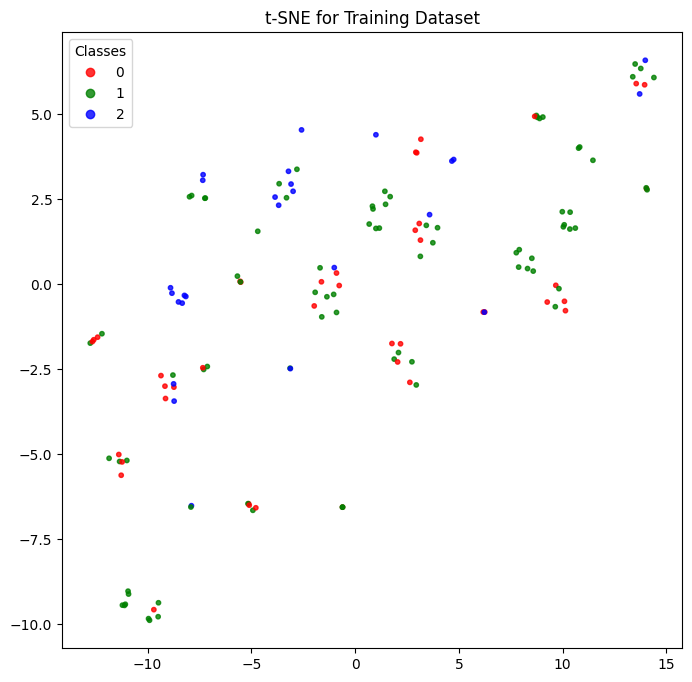

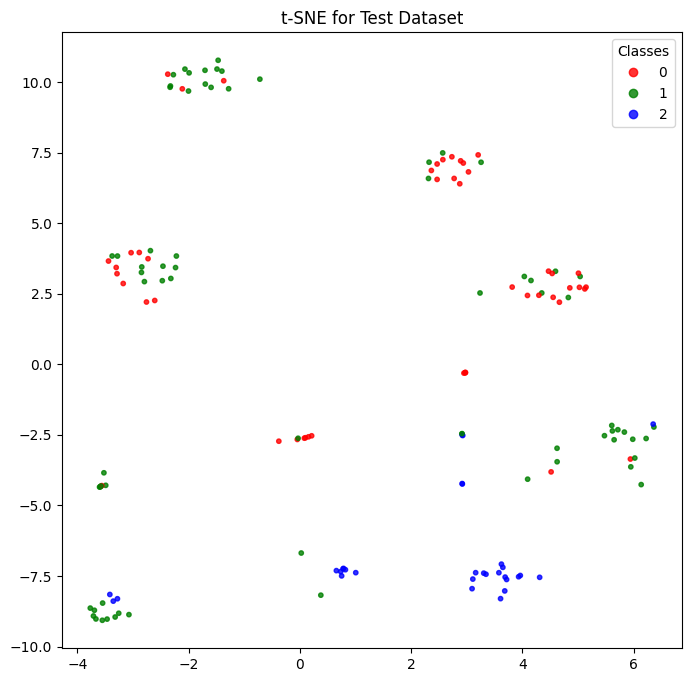

In [50]:
colormap = ListedColormap(['red', 'green', 'blue'])

# Function to plot t-SNE
def plot_tsne(X, y, title):
    plt.figure(figsize=(8, 8))
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap=colormap, s=10, alpha=0.8)
    plt.legend(*scatter.legend_elements(), title="Classes")
    plt.title(title)
    plt.show()

# Load some sample data from train and test sets
n_samples = 150
X_train_sample, y_train_sample = trainset.get_raw_samples(n_samples)
X_test_sample, y_test_sample = testset.get_raw_samples(n_samples)

# Apply t-SNE on the training dataset
tsne = TSNE(n_components=2, random_state=8803)
X_train_tsne = tsne.fit_transform(X_train_sample)

# Apply t-SNE on the test dataset
X_test_tsne = tsne.fit_transform(X_test_sample)

# Plot t-SNE for the training dataset
plot_tsne(X_train_tsne, y_train_sample, title='t-SNE for Training Dataset')

# Plot t-SNE for the test dataset
plot_tsne(X_test_tsne, y_test_sample, title='t-SNE for Test Dataset')


In [12]:
# Initialize the RBF sampler with the desired gamma value
gamma_list = [0.1] 
components_list = [5000]

for components in components_list:
  for gamma in gamma_list:
    print("Training with gamma:", gamma, "num components:", components)
    rbf = RBFSampler(gamma=gamma, n_components=components, random_state=8803)

    # Initialize the SGD classifier with hinge loss and L2 penalty
    svm = SGDClassifier(loss='hinge', penalty='l2')

    # svm = SGDClassifier(loss='hinge', alpha=0.1, max_iter=100, random_state=42)
    scaler = StandardScaler()

    count = 0
    for i, (inputs, labels) in enumerate(train_loader):
      # Convert inputs and labels to numpy arrays
      X_train_batch = inputs.cpu().numpy()
      y_train_batch = labels.cpu().numpy()
      
      X_train_batch = X_train_batch.reshape(X_train_batch.shape[0], -1)
        
      # Transform the input data using the RBF sampler
      X_train_batch = rbf.fit_transform(X_train_batch)
      X_train_batch = scaler.fit_transform(X_train_batch)

      svm.partial_fit(X_train_batch, y_train_batch, classes=np.unique(list(LABELS_Severity.values())))

      count = count + 1
      print("Finished Training Batch:", count)

    y_test = []
    test_pred = []

    for i, (inputs, labels) in enumerate(test_loader):
      X_test_batch = inputs.cpu().numpy()
      y_test_batch = labels.cpu().numpy()
      y_test += y_test_batch.tolist()

      X_test_batch = X_test_batch.reshape(X_test_batch.shape[0], -1)

      X_test_batch = rbf.transform(X_test_batch)
      X_test_batch = scaler.fit_transform(X_test_batch)
      y_pred = svm.predict(X_test_batch)
      test_pred += y_pred.tolist()

      print("Prediction for Test Batch: ", i , " Completed")

    print("Original:", y_test)
    print("Predicted:", test_pred)
    test_balanced_accuracy = balanced_accuracy_score(y_test, test_pred)
    test_f1_score = f1_score(y_test, test_pred, average='weighted')
    print('\nTest Balanced Accuracy: {:0.4f} | Test F1 Score: {:0.4f}'.format(test_balanced_accuracy, test_f1_score))

Training with gamma: 0.1 num components: 5000
Finished Training Batch: 1
Finished Training Batch: 2
Finished Training Batch: 3
Finished Training Batch: 4
Finished Training Batch: 5
Finished Training Batch: 6
Finished Training Batch: 7
Finished Training Batch: 8
Finished Training Batch: 9
Finished Training Batch: 10
Finished Training Batch: 11
Finished Training Batch: 12
Finished Training Batch: 13
Finished Training Batch: 14
Finished Training Batch: 15
Finished Training Batch: 16
Prediction for Test Batch:  0  Completed
Prediction for Test Batch:  1  Completed
Prediction for Test Batch:  2  Completed
Prediction for Test Batch:  3  Completed
Prediction for Test Batch:  4  Completed
Prediction for Test Batch:  5  Completed
Original: [1, 2, 0, 1, 1, 1, 2, 0, 1, 0, 1, 1, 1, 0, 0, 2, 1, 2, 1, 0, 2, 1, 0, 2, 0, 1, 2, 0, 1, 2, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 2, 0, 0, 1, 1, 0, 2, 1, 0, 2, 2, 0, 1, 2, 1, 1, 1, 2, 1, 0, 1, 1, 1, 0, 2, 1, 1, 2, 2, 2, 0, 2, 0, 1, 1, 2, 1, 0, 1, 2, 1, 2, 0, 1, 1, 0, 

In [58]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, test_pred)

# Calculate the sensitivity (recall) for each class
sensitivity = np.diag(cm) / np.sum(cm, axis=1)

# Calculate the specificity for each class
specificity = np.zeros(3)
for i in range(3):
    tp_fp = np.sum(cm[i, :])
    tp_fn = np.sum(cm[:, i])
    tp = cm[i, i]
    tn = np.sum(cm) - tp_fp - tp_fn + tp
    specificity[i] = tn / (tn + tp_fp - tp)

# Calculate the separability (harmonic mean of sensitivity and specificity)
separability = 2 * sensitivity * specificity / (sensitivity + specificity)

print("\nSensitivity (Recall):")
print("Class 0:", sensitivity[0])
print("Class 1:", sensitivity[1])
print("Class 2:", sensitivity[2])

print("\nSeparability:")
print("Class 0:", separability[0])
print("Class 1:", separability[1])
print("Class 2:", separability[2])


Sensitivity (Recall):
Class 0: 0.3269230769230769
Class 1: 0.425
Class 2: 0.41935483870967744

Separability:
Class 0: 0.4425415310840897
Class 1: 0.466013986013986
Class 2: 0.5616264294790343
